In [ ]:
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
import time
 
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks
 
from PIL import Image, ImageSequence
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def resize_vid(width, height, n_pools = 4):
  if(width > 300):
    ratio = 256.0/width
    width = 256
    height *= ratio
  if(height > 300):
    ratio = 256.0/height
    height = 256
    width *= ratio #muze zlobit, muze zmenit na float

  width = int(width)
  height = int(height)
  w = width - (width % np.power(2,n_pools))#abych mohl vyuzivat pooling a pak zpet do stejneho rozliseni
  h = height - (height % np.power(2,n_pools))
  return w, h

#https://stackoverflow.com/questions/33311153/python-extracting-and-saving-video-frames
def load_video(location):
  vidcap = cv2.VideoCapture(location)
  success,image = vidcap.read()
  width  = vidcap.get(3) # float
  height = vidcap.get(4) # float
  width, height = resize_vid(width, height)
  frames = []
  while success:
    image = cv2.resize(image,(width,height),fx=0,fy=0, interpolation = cv2.INTER_CUBIC)
    frames.append(image) 
    success,image = vidcap.read()
  frames = np.array(frames)/256.0 #normalize
  return frames

In [ ]:
#https://stackoverflow.com/questions/41718892/pillow-resizing-a-gif
def resize_gif(path, n_pools = 4, resize_to=None, save_as=None):
    """
    Resizes the GIF to a given length:

    Args:
        path: the path to the GIF file
        save_as (optional): Path of the resized gif. If not set, the original gif will be overwritten.
        resize_to (optional): new size of the gif. Format: (int, int). If not set, the original GIF will be resized to
                              half of its size.
    """
    all_frames = extract_and_resize_frames(path, n_pools, resize_to)

    return all_frames

    if not save_as:
        save_as = path

    if len(all_frames) == 1:
        print("Warning: only 1 frame found")
        all_frames[0].save(save_as, optimize=True)
    else:
        all_frames[0].save(save_as, optimize=True, save_all=True, append_images=all_frames[1:], loop=1000)


def analyseImage(path):
    """
    Pre-process pass over the image to determine the mode (full or additive).
    Necessary as assessing single frames isn't reliable. Need to know the mode
    before processing all frames.
    """
    im = Image.open(path)
    results = {
        'size': im.size,
        'mode': 'full',
    }
    try:
        while True:
            if im.tile:
                tile = im.tile[0]
                update_region = tile[1]
                update_region_dimensions = update_region[2:]
                if update_region_dimensions != im.size:
                    results['mode'] = 'partial'
                    break
            im.seek(im.tell() + 1)
    except EOFError:
        pass
    return results


def extract_and_resize_frames(path, n_pools, resize_to=None):
    """
    Iterate the GIF, extracting each frame and resizing them

    Returns:
        An array of all frames
    """
    mode = analyseImage(path)['mode']

    im = Image.open(path)

    if not resize_to:
        width, height = im.size
        if(width > 256):
          ratio = 256.0/width
          width = 256
          height *= ratio

        if(height > 256):
          ratio = 256.0/height
          height = 256
          width *= ratio #muze zlobit, muze zmenit na float

        w = width - (width % np.power(2,n_pools))
        h = height - (height % np.power(2,n_pools))
        resize_to = (w, h)

    i = 0
    p = im.getpalette()
    last_frame = im.convert('RGBA')

    all_frames = []

    try:
        while True:
            # print("saving %s (%s) frame %d, %s %s" % (path, mode, i, im.size, im.tile))

            '''
            If the GIF uses local colour tables, each frame will have its own palette.
            If not, we need to apply the global palette to the new frame.
            '''
            if not im.getpalette():
                im.putpalette(p)

            new_frame = Image.new('RGBA', im.size)

            '''
            Is this file a "partial"-mode GIF where frames update a region of a different size to the entire image?
            If so, we need to construct the new frame by pasting it on top of the preceding frames.
            '''
            if mode == 'partial':
                new_frame.paste(last_frame)

            new_frame.paste(im, (0, 0), im.convert('RGBA'))



            new_frame.thumbnail(resize_to, Image.ANTIALIAS)
            ##
            (left, upper, right, lower) = (0, 8, 256, 136)
            new_frame = new_frame.crop((left, upper, right, lower)) ##added specifically for anime.gif
            new_frame = new_frame.rotate(90, expand=True)
            ##
            all_frames.append(new_frame)

            i += 1
            last_frame = new_frame
            im.seek(im.tell() + 1)
    except EOFError:
        pass

    return all_frames

In [ ]:
def U_Net_model(input_shape):
  input = layers.Input(input_shape)
  return U_Net_defined_input(input_shape, input)

def U_Net_defined_input(input_shape, input):
  convblock_1 = layers.Conv2D(32, 3, activation='relu', padding='same')(input)
  convblock_1 = layers.BatchNormalization()(convblock_1)
  convblock_1 = layers.Conv2D(32, 3, activation='relu', padding='same')(convblock_1)
  convblock_1 = layers.BatchNormalization()(convblock_1)
  convblock_1_2 = layers.MaxPooling2D(pool_size=2)(convblock_1)

  convblock_2 = layers.Conv2D(64, 3, activation='relu', padding='same')(convblock_1_2)
  convblock_2 = layers.BatchNormalization()(convblock_2)
  convblock_2 = layers.Conv2D(64, 3, activation='relu', padding='same')(convblock_2)
  convblock_2 = layers.BatchNormalization()(convblock_2)
  convblock_2_3 = layers.MaxPooling2D(pool_size=2)(convblock_2)

  convblock_3 = layers.Conv2D(128, 3, activation='relu', padding='same')(convblock_2_3)
  convblock_3 = layers.BatchNormalization()(convblock_3)
  convblock_3 = layers.Conv2D(128, 3, activation='relu', padding='same')(convblock_3)
  convblock_3 = layers.BatchNormalization()(convblock_3)
  convblock_3_4 = layers.MaxPooling2D(pool_size=2)(convblock_3)

  convblock_4 = layers.Conv2D(256, 3, activation='relu', padding='same')(convblock_3_4)
  convblock_4 = layers.BatchNormalization()(convblock_4)
  convblock_4 = layers.Conv2D(256, 3, activation='relu', padding='same')(convblock_4)
  convblock_4 = layers.BatchNormalization()(convblock_4)
  convblock_4_5 = layers.MaxPooling2D(pool_size=2)(convblock_4)

  block_5 = layers.Conv2D(512, 3, activation='relu', padding='same')(convblock_4_5)
  block_5 = layers.BatchNormalization()(block_5)
  block_5 = layers.Conv2D(512, 3, activation='relu', padding='same')(block_5)
  block_5 = layers.BatchNormalization()(block_5)

  deconvblock_4 = layers.UpSampling2D(size=2)(block_5)
  #deconvblock_4 = layers.Conv2DTranspose(256, (3, 3), strides=(1, 1), padding='same', activation='relu')(block_5)
  #deconvblock_4 = layers.Conv2D(256, 3, activation='relu', padding='same')(deconvblock_4)
  #deconvblock_4 = layers.BatchNormalization()(deconvblock_4)
  deconvblock_4 = layers.concatenate([deconvblock_4, convblock_4], axis=3)
  deconvblock_4 = layers.Conv2D(256, 3, activation='relu', padding='same')(deconvblock_4)
  deconvblock_4 = layers.BatchNormalization()(deconvblock_4)
  deconvblock_4 = layers.Conv2D(256, 3, activation='relu', padding='same')(deconvblock_4)
  deconvblock_4 = layers.BatchNormalization()(deconvblock_4)

  deconvblock_3 = layers.UpSampling2D(size=2)(deconvblock_4)
  #deconvblock_3 = layers.Conv2D(128, 3, activation='relu', padding='same')(deconvblock_3)
  #deconvblock_3 = layers.BatchNormalization()(deconvblock_3)
  deconvblock_3 = layers.concatenate([deconvblock_3, convblock_3], axis=3)
  deconvblock_3 = layers.Conv2D(128, 3, activation='relu', padding='same')(deconvblock_3)
  deconvblock_3 = layers.BatchNormalization()(deconvblock_3)
  deconvblock_3 = layers.Conv2D(128, 3, activation='relu', padding='same')(deconvblock_3)
  deconvblock_3 = layers.BatchNormalization()(deconvblock_3)

  deconvblock_2 = layers.UpSampling2D(size=2)(deconvblock_3)
  #deconvblock_2 = layers.Conv2D(64, 3, activation='relu', padding='same')(deconvblock_2)
  #deconvblock_2 = layers.BatchNormalization()(deconvblock_2)
  deconvblock_2 = layers.concatenate([deconvblock_2, convblock_2], axis=3)
  deconvblock_2 = layers.Conv2D(64, 3, activation='relu', padding='same')(deconvblock_2)
  deconvblock_2 = layers.BatchNormalization()(deconvblock_2)
  deconvblock_2 = layers.Conv2D(64, 3, activation='relu', padding='same')(deconvblock_2)
  deconvblock_2 = layers.BatchNormalization()(deconvblock_2)

  deconvblock_1 = layers.UpSampling2D(size=2)(deconvblock_2)
  #deconvblock_1 = layers.Conv2D(32, 3, activation='relu', padding='same')(deconvblock_1)
  #deconvblock_1 = layers.BatchNormalization()(deconvblock_1)
  deconvblock_1 = layers.concatenate([deconvblock_1, convblock_1], axis=3)
  deconvblock_1 = layers.Conv2D(32, 3, activation='relu', padding='same')(deconvblock_1)
  deconvblock_1 = layers.BatchNormalization()(deconvblock_1)
  deconvblock_1 = layers.Conv2D(32, 3, activation='relu', padding='same')(deconvblock_1)
  deconvblock_1 = layers.BatchNormalization()(deconvblock_1)


  output = layers.Conv2D(input_shape[2]/2, 3, activation='sigmoid', padding='same')(deconvblock_1)


  model = models.Model(input, output, name='u_net')
  #display(model.summary())
  return model


In [ ]:
def split_frames(frames):
  X, y = list(), list()
  for i in range(frames.shape[0] - 2):
    X.append(np.concatenate((frames[i], frames[i+2]), axis=2))
    y.append(frames[i+1])
  return np.array(X),np.array(y)


In [ ]:
 def load_gif(path, n_pools = 4):
  tmp = resize_gif(path, n_pools)
  frames = np.array([np.array(frame.copy().convert('RGB').getdata(),dtype=np.uint8).reshape(frame.size[1],frame.size[0],3) for frame in tmp]) /256.0 #normalize
  return frames[:,:,:,::-1] #BGR


#Start

In [ ]:
frames = load_video('/content/drive/My Drive/kocka.mp4')
frames.shape

(159, 256, 128, 3)

In [ ]:
gif = load_gif("/content/drive/My Drive/anime.gif")

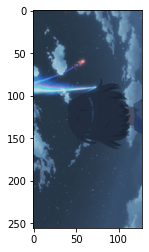

In [ ]:
#gif=np.rot90(gif, -1, (1,2))
plt.imshow(gif[20][:, :, ::-1])

In [ ]:
X1,y1 = split_frames(frames)
print(X1.shape)
print(y1.shape)

(157, 256, 128, 6)
(157, 256, 128, 3)


In [ ]:
X2,y2 = split_frames(gif)
print(X2.shape)
print(y2.shape)

(72, 256, 128, 6)
(72, 256, 128, 3)


In [ ]:
X = np.concatenate([X1, X2], axis = 0)
y = np.concatenate([y1, y2], axis = 0)
print(X.shape)
print(y.shape)

(229, 256, 128, 6)
(229, 256, 128, 3)


In [ ]:
input = X[0]
model = U_Net_model(input.shape)

In [ ]:
history = []
early_stopping_callback = callbacks.EarlyStopping(monitor='val_loss', patience=60)
checkpoint_filepath = '/content/drive/My Drive/kocka_a_anime/U_Net/u_net_1'
model_checkpoint_callback = callbacks.ModelCheckpoint(
      filepath=checkpoint_filepath,
      save_weights_only=True,
      monitor='val_loss',
      mode='min',
      save_best_only=True)
i = 0
lrates = [1e-3,1e-4,1e-5]
while True:
  model.load_weights(checkpoint_filepath)
  i = i+1
  i = i%3
  optimizer = optimizers.Adam(lr = lrates[i], beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-08)
  model.compile(optimizer=optimizer, loss='mse')
  epochs = model.fit(X, y, batch_size=64, epochs=100000, callbacks=[model_checkpoint_callback, early_stopping_callback], validation_split = 0.2)
  history.append(epochs)

Epoch 1/100000
3/3 [==============================] - 4s 880ms/step - loss: 2.0854e-04 - val_loss: 2.7570e-04
Epoch 2/100000
3/3 [==============================] - 2s 745ms/step - loss: 1.9640e-04 - val_loss: 2.7582e-04
Epoch 3/100000
3/3 [==============================] - 2s 735ms/step - loss: 1.9138e-04 - val_loss: 2.7615e-04
Epoch 4/100000
3/3 [==============================] - 2s 739ms/step - loss: 1.8980e-04 - val_loss: 2.7358e-04
Epoch 5/100000
3/3 [==============================] - 2s 741ms/step - loss: 1.9770e-04 - val_loss: 2.8085e-04
Epoch 6/100000
3/3 [==============================] - 2s 746ms/step - loss: 2.1194e-04 - val_loss: 2.8043e-04
Epoch 7/100000
3/3 [==============================] - 2s 743ms/step - loss: 2.1189e-04 - val_loss: 2.7593e-04
Epoch 8/100000
3/3 [==============================] - 2s 739ms/step - loss: 2.4043e-04 - val_loss: 2.7686e-04
Epoch 9/100000
3/3 [==============================] - 2s 755ms/step - loss: 1.8388e-04 - val_loss: 2.7703e-04
Epoch 10/1

KeyboardInterrupt: ignored

## Generovani gifu

In [ ]:
load_filepath = '/content/drive/My Drive/kocka_a_anime/U_Net/u_net_1'
model.load_weights(load_filepath)

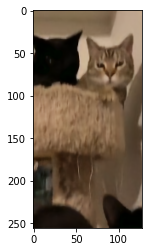

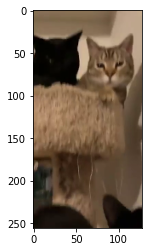

In [ ]:
#Generuj "puvodni videa"
generated_images = model.predict(X)
frame_id = 90
plt.imshow(generated_images[frame_id][:, :, ::-1])
plt.show()
plt.imshow(y[frame_id][:, :, ::-1])
#generated_images[54]

In [ ]:
def interpolation_input(frames):
  X = list()
  for i in range(frames.shape[0] - 1):
    X.append(np.concatenate((frames[i], frames[i+1]), axis=2))
  return np.array(X)

def join_frames(output, interpolated_frames):
  result = []
  result.append(output[0])
  for i in range(1, output.shape[0]):
    result.append(interpolated_frames[i - 1])
    result.append(output[i])

  return np.array(result)

In [ ]:
#Generuj "zpomalene video"
def interpolate_frames(frames, n_times):
  output = frames.copy()
  for i in range(n_times):
    input = interpolation_input(output)
    interpolated_frames = model.predict(input)
    output = join_frames(output, interpolated_frames)
  return output

In [ ]:
interpolated_frames = interpolate_frames(gif, 1)

In [ ]:
def plot_frames(interpolated_frames, starting_frame = 0):
  plt.imshow(interpolated_frames[starting_frame][:, :, ::-1])
  plt.show()
  plt.imshow(interpolated_frames[starting_frame + 1][:, :, ::-1])
  plt.show()
  plt.imshow(interpolated_frames[starting_frame + 2][:, :, ::-1])

In [ ]:
plot_frames(interpolated_frames, 50)

In [ ]:
import imageio
def create_gif(frames, filename):
  with imageio.get_writer(filename, mode='I') as writer:
    for frame in frames:
      writer.append_data(frame)
    writer.append_data(frame)
  return

create_gif(interpolated_frames[:, :, :, ::-1], '/content/drive/My Drive/kocka_mp4/U_Net/generated/interpolated_2.gif')

In [ ]:
def chain_u_nets(input_shape):
  model1 = U_Net_model(input_shape)
  model1.load_weights(checkpoint_filepath).expect_partial()
  model2 = U_Net_model(input_shape)
  model2.load_weights(checkpoint_filepath)
  model3 = U_Net_model(input_shape)
  model3.load_weights(checkpoint_filepath).expect_partial()
  m3input = concatenate([model1.output, model2.output], axis=3)

  model = Model(inputs=[model1.input, model2.input], outputs=model2(m3input), name='u_net')
  optimizer = Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-08)
  model.compile(optimizer=optimizer, loss='mse')
  #display(model.summary())
  return model
  
#chain_u_nets((input.shape[0], input.shape[1], input.shape[2]*2))

In [ ]:
filepath ="/content/drive/My Drive/kocka_mp4/U_Net/generated/generated_12000.gif"
gif = load_gif(filepath)
#create_gif(gif[:, :, :, ::-1], filepath)

In [ ]:
lst = []
for i in range(interpolated_frames.shape[0]):
  first = interpolated_frames[i]
  last = interpolated_frames[i+1]
  tmp = np.concatenate((first, last), axis=2)
  lst.append(tmp)
  arr = np.array(lst)
  res = model.predict(arr)
  print(np.mean(np.abs(first - res)), np.mean(np.abs(last - res)))